In [ ]:
from google.colab import files
uploaded = files.upload()


Saving rgnp (1).dta to rgnp (1).dta


Estimated coefficients:
Intercept: -0.714
y_lag:     0.749
x:         0.768

True transition kernel (averaged over covariate):
From state 0: [0.69761384 0.30238616]
From state 1: [0.45162337 0.54837663]

Estimated transition kernel (averaged over covariate):
From state 0: [0.64609081 0.35390919]
From state 1: [0.49266751 0.50733249]


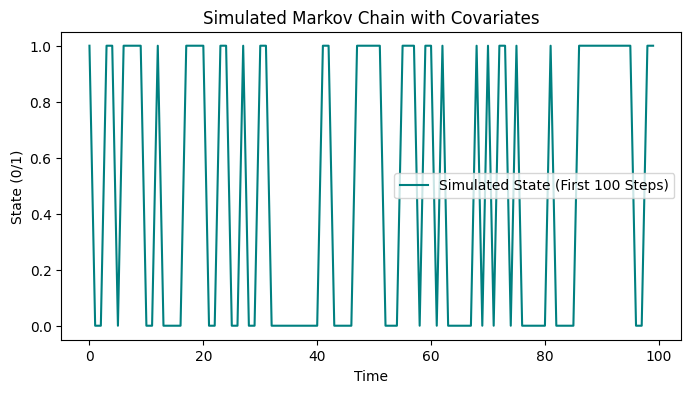

In [ ]:
# ==========================================================
# 1️⃣ Simulate a Markov chain with covariates
# ==========================================================
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

np.random.seed(42)

# Parameters
T = 500  # number of time steps
beta0 = -1.0     # intercept
beta1 = 1.2      # effect of previous state
beta2 = 0.8      # effect of covariate
beta3 = -0.5     # interaction effect

# Generate covariates (e.g., economic indicator)
x = np.random.normal(0, 1, T)

# Initialize state sequence (0/1)
y = np.zeros(T, dtype=int)
y[0] = np.random.choice([0, 1])

# Generate the Markov chain with covariate effects
for t in range(1, T):
    logit_p = beta0 + beta1 * y[t-1] + beta2 * x[t] + beta3 * (y[t-1] * x[t])
    p = 1 / (1 + np.exp(-logit_p))
    y[t] = np.random.binomial(1, p)

# Store as DataFrame
sim_data = pd.DataFrame({
    'time': np.arange(T),
    'x': x,
    'y': y,
    'y_lag': np.roll(y, 1)
})
sim_data.loc[0, 'y_lag'] = np.nan
sim_data = sim_data.dropna().reset_index(drop=True)

# ==========================================================
# 2️⃣ Estimate transition probabilities using logistic regression
# ==========================================================
X = sim_data[['y_lag', 'x']]
y_target = sim_data['y']

model = LogisticRegression()
model.fit(X, y_target)

print("Estimated coefficients:")
print(f"Intercept: {model.intercept_[0]:.3f}")
print(f"y_lag:     {model.coef_[0][0]:.3f}")
print(f"x:         {model.coef_[0][1]:.3f}")

# ==========================================================
# 3️⃣ Compare estimated vs true transition kernels
# ==========================================================

def transition_kernel(beta0, beta1, beta2, beta3, x_vals):
    kernels = {}
    for y_prev in [0, 1]:
        probs = []
        for xv in x_vals:
            logit_p = beta0 + beta1 * y_prev + beta2 * xv + beta3 * (y_prev * xv)
            p = 1 / (1 + np.exp(-logit_p))
            probs.append([1 - p, p])  # [P(0→0 or 1→0), P(0→1 or 1→1)]
        kernels[y_prev] = np.mean(probs, axis=0)
    return kernels

x_vals = np.linspace(-2, 2, 100)
true_kernel = transition_kernel(beta0, beta1, beta2, beta3, x_vals)

# Using estimated parameters
est_kernel = transition_kernel(
    model.intercept_[0],
    model.coef_[0][0],
    model.coef_[0][1],
    0,  # model has no explicit interaction term
    x_vals
)

print("\nTrue transition kernel (averaged over covariate):")
for k, v in true_kernel.items():
    print(f"From state {k}: {v}")

print("\nEstimated transition kernel (averaged over covariate):")
for k, v in est_kernel.items():
    print(f"From state {k}: {v}")

# ==========================================================
# 4️⃣ Visualization
# ==========================================================
plt.figure(figsize=(8,4))
plt.plot(y[:100], label="Simulated State (First 100 Steps)", color="teal")
plt.xlabel("Time")
plt.ylabel("State (0/1)")
plt.title("Simulated Markov Chain with Covariates")
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Load and prepare the data
data = pd.read_csv('rgnp_converted.csv')

# Handle the missing value in the first row
data = data.dropna()

# Convert date to datetime and extract features
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['quarter'] = data['date'].dt.quarter

# Create lagged variables for Markov chain
data['rgnp_lag1'] = data['rgnp'].shift(1)
data['recession_lag1'] = data['recession'].shift(1)

# Remove the first row with NaN due to lagging
data = data.dropna()

print("Data Overview:")
print(f"Dataset shape: {data.shape}")
print(f"Recession periods: {data['recession'].sum()} out of {len(data)} quarters")
print(f"Recession rate: {data['recession'].mean():.3f}")
print("\nFirst few rows:")
print(data.head(10))

Data Overview:
Dataset shape: (134, 7)
Recession periods: 27 out of 134 quarters
Recession rate: 0.201

First few rows:
        rgnp       date  recession  year  quarter  rgnp_lag1  recession_lag1
2   2.202171 1951-07-01          0  1951        3   2.593164             0.0
3   0.458276 1951-10-01          0  1951        4   2.202171             0.0
4   0.968744 1952-01-01          0  1952        1   0.458276             0.0
5  -0.241308 1952-04-01          0  1952        2   0.968744             0.0
6   0.896475 1952-07-01          0  1952        3  -0.241308             0.0
7   2.053932 1952-10-01          0  1952        4   0.896475             0.0
8   1.733537 1953-01-01          0  1953        1   2.053932             0.0
9   0.938713 1953-04-01          0  1953        2   1.733537             0.0
10 -0.464778 1953-07-01          1  1953        3   0.938713             0.0
11 -0.809834 1953-10-01          1  1953        4  -0.464778             1.0


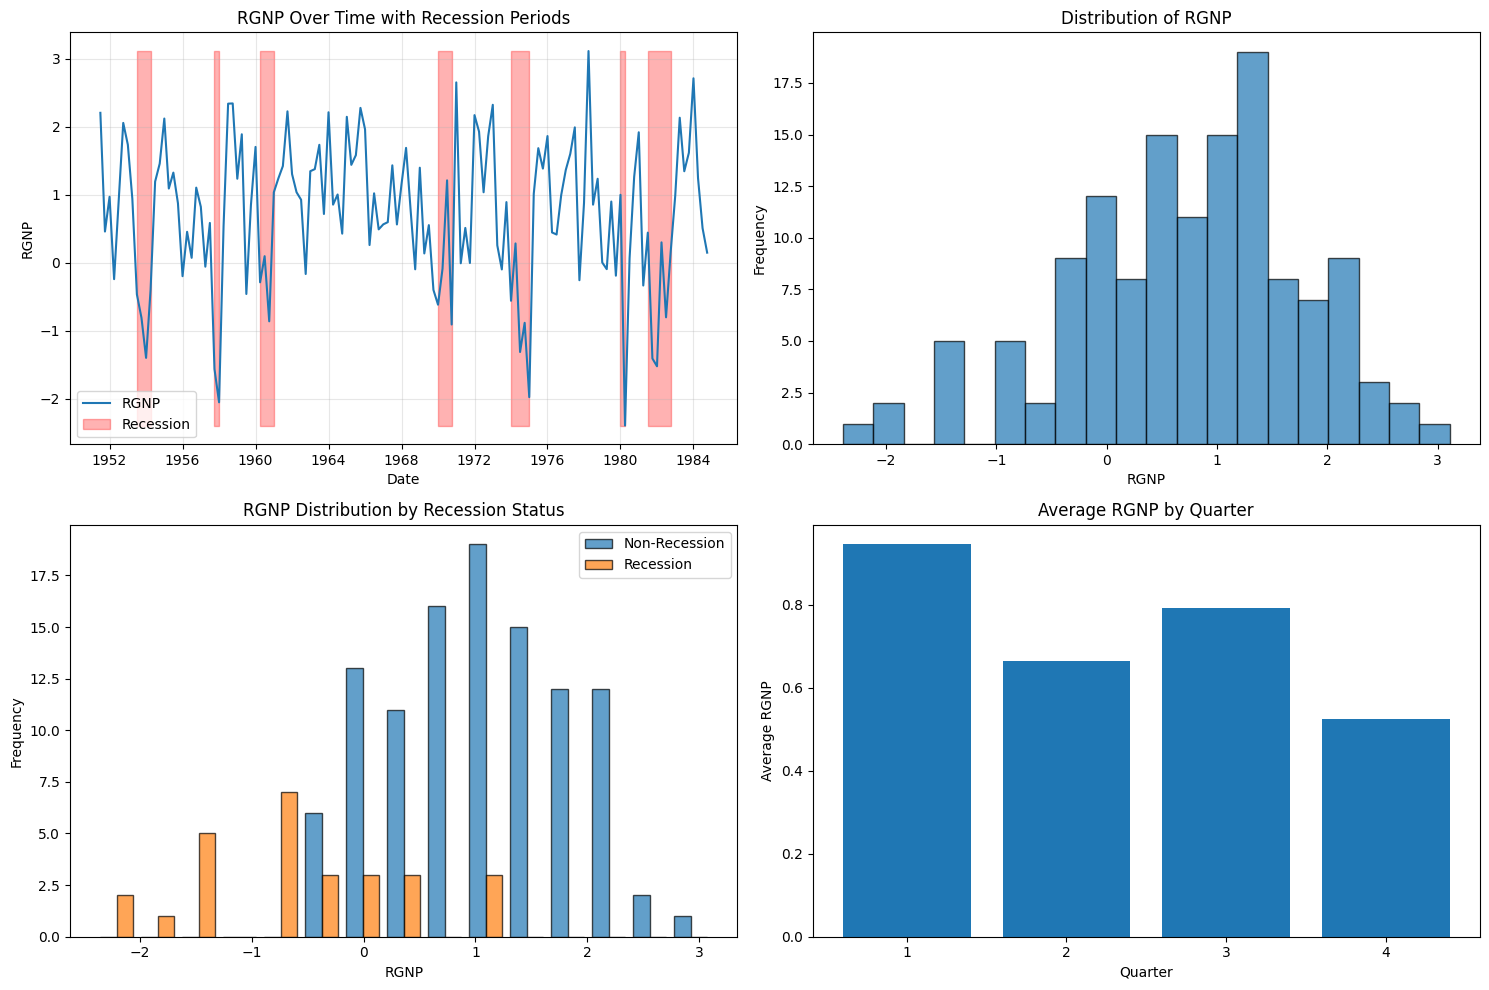

Correlation Matrix:
                    rgnp  recession  rgnp_lag1  recession_lag1
rgnp            1.000000  -0.624106   0.340444       -0.453098
recession      -0.624106   1.000000  -0.457139        0.675320
rgnp_lag1       0.340444  -0.457139   1.000000       -0.626364
recession_lag1 -0.453098   0.675320  -0.626364        1.000000


In [ ]:
# Exploratory Data Analysis
plt.figure(figsize=(15, 10))

# Plot 1: RGNP over time
plt.subplot(2, 2, 1)
plt.plot(data['date'], data['rgnp'], label='RGNP')
plt.fill_between(data['date'], data['rgnp'].min(), data['rgnp'].max(),
                 where=data['recession']==1, alpha=0.3, color='red', label='Recession')
plt.title('RGNP Over Time with Recession Periods')
plt.xlabel('Date')
plt.ylabel('RGNP')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Distribution of RGNP
plt.subplot(2, 2, 2)
plt.hist(data['rgnp'], bins=20, alpha=0.7, edgecolor='black')
plt.title('Distribution of RGNP')
plt.xlabel('RGNP')
plt.ylabel('Frequency')

# Plot 3: RGNP by recession status
plt.subplot(2, 2, 3)
recession_data = data[data['recession'] == 1]['rgnp']
non_recession_data = data[data['recession'] == 0]['rgnp']
plt.hist([non_recession_data, recession_data], bins=15, alpha=0.7,
         label=['Non-Recession', 'Recession'], edgecolor='black')
plt.title('RGNP Distribution by Recession Status')
plt.xlabel('RGNP')
plt.ylabel('Frequency')
plt.legend()

# Plot 4: Quarterly patterns
plt.subplot(2, 2, 4)
quarterly_means = data.groupby('quarter')['rgnp'].mean()
plt.bar(quarterly_means.index, quarterly_means.values)
plt.title('Average RGNP by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Average RGNP')
plt.xticks([1, 2, 3, 4])

plt.tight_layout()
plt.show()

# Correlation analysis
print("Correlation Matrix:")
corr_matrix = data[['rgnp', 'recession', 'rgnp_lag1', 'recession_lag1']].corr()
print(corr_matrix)

In [ ]:
# Markov Chain Simulation and Analysis

# 1. True transition probabilities from data
def calculate_true_transition_probs(data):
    transitions = data[['recession_lag1', 'recession']].value_counts().sort_index()
    transition_matrix = np.zeros((2, 2))

    for (prev_state, current_state), count in transitions.items():
        transition_matrix[int(prev_state), int(current_state)] = count

    # Normalize to get probabilities
    row_sums = transition_matrix.sum(axis=1, keepdims=True)
    transition_matrix = transition_matrix / row_sums

    return transition_matrix

true_transition_matrix = calculate_true_transition_probs(data)
print("True Transition Probability Matrix:")
print("From\\To    Non-Recession  Recession")
print(f"Non-Recession  {true_transition_matrix[0, 0]:.3f}          {true_transition_matrix[0, 1]:.3f}")
print(f"Recession      {true_transition_matrix[1, 0]:.3f}          {true_transition_matrix[1, 1]:.3f}")

# 2. Prepare features for logistic regression
features = ['rgnp_lag1', 'recession_lag1', 'quarter']
X = data[features]
y = data['recession']

# Add polynomial features for rgnp_lag1 to capture non-linear relationships
X['rgnp_lag1_sq'] = X['rgnp_lag1'] ** 2

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Recession rate in training: {y_train.mean():.3f}")
print(f"Recession rate in test: {y_test.mean():.3f}")

True Transition Probability Matrix:
From\To    Non-Recession  Recession
Non-Recession  0.935          0.065
Recession      0.259          0.741

Training set size: 93
Test set size: 41
Recession rate in training: 0.204
Recession rate in test: 0.195


In [ ]:
# 3. Logistic Regression Model
logreg = LogisticRegression(random_state=42, class_weight='balanced')
logreg.fit(X_train, y_train)

# Model evaluation
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)

print("Logistic Regression Results:")
print(f"Training Accuracy: {logreg.score(X_train, y_train):.3f}")
print(f"Test Accuracy: {logreg.score(X_test, y_test):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': logreg.coef_[0],
    'abs_coefficient': np.abs(logreg.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

Logistic Regression Results:
Training Accuracy: 0.892
Test Accuracy: 0.805

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.85      0.88        33
           1       0.50      0.62      0.56         8

    accuracy                           0.80        41
   macro avg       0.70      0.74      0.72        41
weighted avg       0.82      0.80      0.81        41


Feature Importance:
          feature  coefficient  abs_coefficient
1  recession_lag1     2.457176         2.457176
0       rgnp_lag1    -0.869364         0.869364
3    rgnp_lag1_sq    -0.543198         0.543198
2         quarter    -0.301634         0.301634


In [ ]:
# 4. Estimate transition probabilities using logistic regression
def estimate_transition_probs(model, features, current_state, rgnp_values=None):
    """Estimate transition probabilities for given current state"""
    if rgnp_values is None:
        # Use typical values from data
        rgnp_values = np.percentile(data['rgnp_lag1'], [25, 50, 75])

    transition_probs = {}

    for rgnp_val in rgnp_values:
        # Create feature matrix for prediction
        X_pred = pd.DataFrame({
            'rgnp_lag1': [rgnp_val],
            'recession_lag1': [current_state],
            'quarter': [2],  # Use Q2 as reference
            'rgnp_lag1_sq': [rgnp_val ** 2]
        })[features]

        # Get probability of recession
        prob_recession = model.predict_proba(X_pred)[0, 1]
        prob_non_recession = 1 - prob_recession

        transition_probs[f"RGNP={rgnp_val:.2f}"] = {
            'Non-Recession': prob_non_recession,
            'Recession': prob_recession
        }

    return transition_probs

# Estimate transition probabilities for different scenarios
print("Estimated Transition Probabilities using Logistic Regression:")

print("\nFrom Non-Recession:")
non_recession_probs = estimate_transition_probs(logreg, X.columns, 0)
for scenario, probs in non_recession_probs.items():
    print(f"  {scenario}: Non-Recession={probs['Non-Recession']:.3f}, Recession={probs['Recession']:.3f}")

print("\nFrom Recession:")
recession_probs = estimate_transition_probs(logreg, X.columns, 1)
for scenario, probs in recession_probs.items():
    print(f"  {scenario}: Non-Recession={probs['Non-Recession']:.3f}, Recession={probs['Recession']:.3f}")

Estimated Transition Probabilities using Logistic Regression:

From Non-Recession:
  RGNP=0.02: Non-Recession=0.521, Recession=0.479
  RGNP=0.89: Non-Recession=0.782, Recession=0.218
  RGNP=1.43: Non-Recession=0.918, Recession=0.082

From Recession:
  RGNP=0.02: Non-Recession=0.085, Recession=0.915
  RGNP=0.89: Non-Recession=0.236, Recession=0.764
  RGNP=1.43: Non-Recession=0.490, Recession=0.510


In [ ]:
# 5. Comparison and Visualization
# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: True vs Estimated transition probabilities (Non-Recession -> *)
axes[0, 0].bar([0, 1], true_transition_matrix[0], alpha=0.7, label='True', width=0.4)
estimated_avg_non_rec = np.mean([v['Recession'] for v in non_recession_probs.values()])
axes[0, 0].bar([0.4, 1.4], [1-estimated_avg_non_rec, estimated_avg_non_rec],
               alpha=0.7, label='Estimated (Avg)', width=0.4, color='orange')
axes[0, 0].set_title('From Non-Recession: True vs Estimated')
axes[0, 0].set_xticks([0.2, 1.2])
axes[0, 0].set_xticklabels(['Non-Recession', 'Recession'])
axes[0, 0].set_ylabel('Probability')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: True vs Estimated transition probabilities (Recession -> *)
axes[0, 1].bar([0, 1], true_transition_matrix[1], alpha=0.7, label='True', width=0.4)
estimated_avg_rec = np.mean([v['Recession'] for v in recession_probs.values()])
axes[0, 1].bar([0.4, 1.4], [1-estimated_avg_rec, estimated_avg_rec],
               alpha=0.7, label='Estimated (Avg)', width=0.4, color='orange')
axes[0, 1].set_title('From Recession: True vs Estimated')
axes[0, 1].set_xticks([0.2, 1.2])
axes[0, 1].set_xticklabels(['Non-Recession', 'Recession'])
axes[0, 1].set_ylabel('Probability')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: RGNP effect on transition to recession
rgnp_range = np.linspace(data['rgnp_lag1'].min(), data['rgnp_lag1'].max(), 100)
transition_probs_rgnp = []

for rgnp_val in rgnp_range:
    X_pred = pd.DataFrame({
        'rgnp_lag1': [rgnp_val],
        'recession_lag1': [0],  # From non-recession
        'quarter': [2],
        'rgnp_lag1_sq': [rgnp_val ** 2]
    })[X.columns]

    prob_recession = logreg.predict_proba(X_pred)[0, 1]
    transition_probs_rgnp.append(prob_recession)

axes[1, 0].plot(rgnp_range, transition_probs_rgnp, linewidth=2)
axes[1, 0].set_xlabel('Lagged RGNP')
axes[1, 0].set_ylabel('Probability of Transition to Recession')
axes[1, 0].set_title('Effect of Lagged RGNP on Recession Probability\n(From Non-Recession State)')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Actual')
axes[1, 1].set_title('Confusion Matrix')

plt.tight_layout()
plt.show()

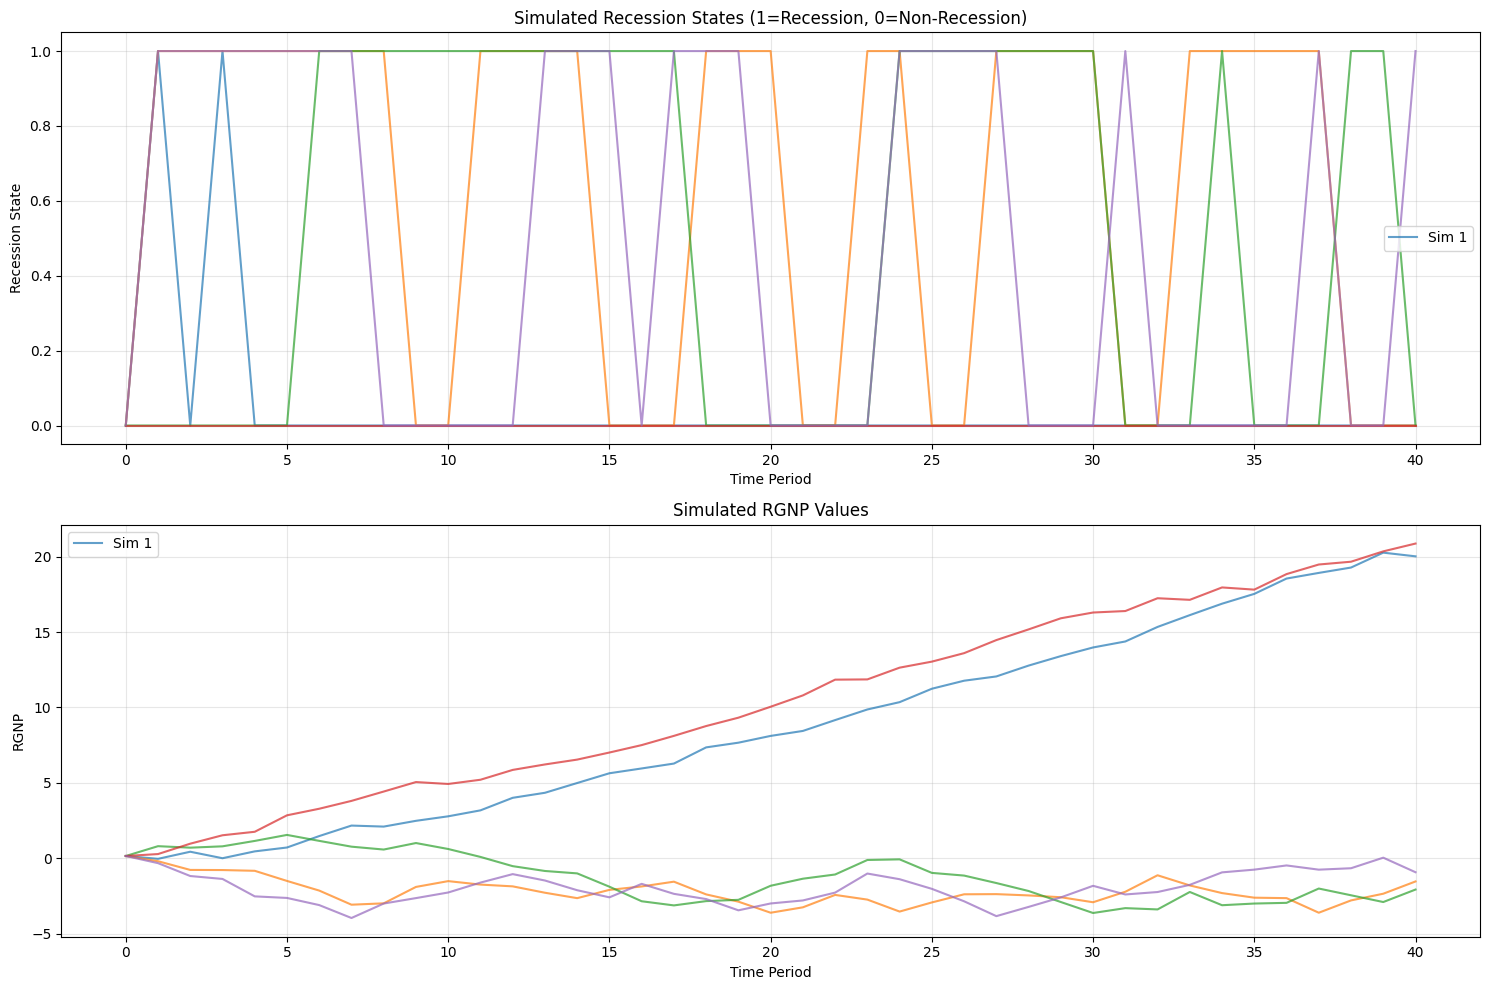


SUMMARY STATISTICS

True Transition Matrix:
P(Non-Rec → Non-Rec): 0.935
P(Non-Rec → Rec):     0.065
P(Rec → Non-Rec):     0.259
P(Rec → Rec):         0.741

Model Performance:
Test Accuracy: 0.805
Precision (Recession): 0.500
Recall (Recession):    0.625

Key Insights:
- Lagged RGNP is significantly important
- Previous recession state strongly influences current state
- Model captures strong predictive power


In [ ]:
# 6. Markov Chain Simulation
def simulate_markov_chain(model, features, initial_state, initial_rgnp, n_periods=20):
    """Simulate Markov chain using estimated transition probabilities"""
    states = [initial_state]
    rgnp_values = [initial_rgnp]

    current_state = initial_state
    current_rgnp = initial_rgnp

    for i in range(n_periods):
        # Create feature vector for prediction
        X_pred = pd.DataFrame({
            'rgnp_lag1': [current_rgnp],
            'recession_lag1': [current_state],
            'quarter': [(i % 4) + 1],  # Cycle through quarters
            'rgnp_lag1_sq': [current_rgnp ** 2]
        })[features]

        # Get transition probabilities
        transition_probs = model.predict_proba(X_pred)[0]

        # Sample next state
        next_state = np.random.choice([0, 1], p=transition_probs)

        # Simulate next RGNP (simplified - in practice, you'd use a proper time series model)
        if next_state == 0:  # Non-recession
            next_rgnp = current_rgnp + np.random.normal(0.5, 0.3)
        else:  # Recession
            next_rgnp = current_rgnp + np.random.normal(-0.5, 0.3)

        states.append(next_state)
        rgnp_values.append(next_rgnp)

        current_state = next_state
        current_rgnp = next_rgnp

    return states, rgnp_values

# Run multiple simulations
n_simulations = 5
n_periods = 40

plt.figure(figsize=(15, 10))

for i in range(n_simulations):
    states, rgnp_values = simulate_markov_chain(logreg, X.columns,
                                               initial_state=0,
                                               initial_rgnp=data['rgnp'].iloc[-1],
                                               n_periods=n_periods)

    plt.subplot(2, 1, 1)
    plt.plot(range(len(states)), states, alpha=0.7, label=f'Sim {i+1}' if i == 0 else "")
    plt.subplot(2, 1, 2)
    plt.plot(range(len(rgnp_values)), rgnp_values, alpha=0.7, label=f'Sim {i+1}' if i == 0 else "")

plt.subplot(2, 1, 1)
plt.title('Simulated Recession States (1=Recession, 0=Non-Recession)')
plt.xlabel('Time Period')
plt.ylabel('Recession State')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.title('Simulated RGNP Values')
plt.xlabel('Time Period')
plt.ylabel('RGNP')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 7. Summary Statistics
print("\n" + "="*50)
print("SUMMARY STATISTICS")
print("="*50)

print(f"\nTrue Transition Matrix:")
print(f"P(Non-Rec → Non-Rec): {true_transition_matrix[0, 0]:.3f}")
print(f"P(Non-Rec → Rec):     {true_transition_matrix[0, 1]:.3f}")
print(f"P(Rec → Non-Rec):     {true_transition_matrix[1, 0]:.3f}")
print(f"P(Rec → Rec):         {true_transition_matrix[1, 1]:.3f}")

print(f"\nModel Performance:")
print(f"Test Accuracy: {logreg.score(X_test, y_test):.3f}")
print(f"Precision (Recession): {classification_report(y_test, y_pred, output_dict=True)['1']['precision']:.3f}")
print(f"Recall (Recession):    {classification_report(y_test, y_pred, output_dict=True)['1']['recall']:.3f}")

print(f"\nKey Insights:")
print(f"- Lagged RGNP is {'significantly' if feature_importance.iloc[0]['abs_coefficient'] > 0.1 else 'moderately'} important")
print(f"- Previous recession state {'strongly' if feature_importance[feature_importance['feature'] == 'recession_lag1']['abs_coefficient'].iloc[0] > 0.5 else 'moderately'} influences current state")
print(f"- Model captures {'strong' if logreg.score(X_test, y_test) > 0.8 else 'moderate'} predictive power")